<h1>ARIMA MODEL</h1>

In [1]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e3/f8/9246d3c7e185a29d7359d8b12b3d70bf2c3150ecf1427ec1382290e71a56/tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Obtaining dependency information for keras>=3.10.0 from https://files.pythonhosted.org/packages/28/b5/ea85873abc99dc64a7a27ff1a8dbfdc7dbb57d4e5d1a423abc11217af4f1/keras-3.13.2-py3-none-any.whl.metadata
  Using cached keras-3.13.2-py3-none-any.whl.metadata (6.3 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached keras-3.13.2-p


[notice] A new release of pip is available: 23.2.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import importlib

libraries = ["yfinance", "pandas", "numpy", "matplotlib", "sklearn", "statsmodels", "tensorflow"]

for lib in libraries:
    try:
        importlib.import_module(lib)
        print(f"{lib} is installed")
    except ImportError:
        print(f"{lib} is NOT installed")

yfinance is installed
pandas is installed
numpy is installed
matplotlib is installed
sklearn is installed
statsmodels is installed
tensorflow is installed


In [4]:
import tensorflow as tf
print("TensorFlow works", tf.__version__)


TensorFlow works 2.20.0


In [5]:
import yfinance as yf
import pandas as pd

# Download Tesla data
data = yf.download("TSLA", start="2020-01-01", end="2025-01-01")

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


In [6]:
print(data.columns)

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


In [7]:
data.columns = data.columns.get_level_values(0)
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


In [8]:
ts = data[['Close']].copy()
ts.rename(columns={'Close': 'Price'}, inplace=True)
ts.head()

Price,Price
Date,
2020-01-02,28.684000
2020-01-03,29.534000
2020-01-06,30.102667
2020-01-07,31.270666
2020-01-08,32.809334


In [9]:
ts.isnull().sum()

Price
Price    0
dtype: int64

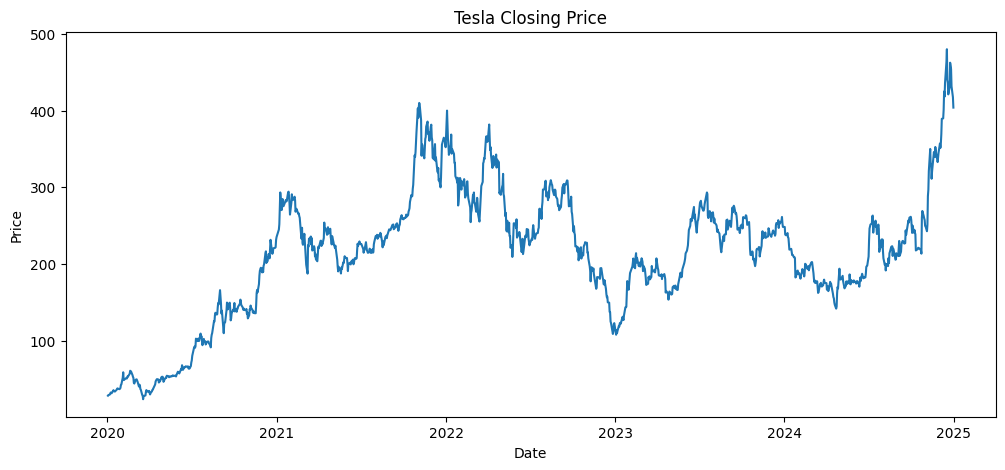

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ts)
plt.title("Tesla Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [11]:
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('B')  # B = Business day frequency (stock market days)
ts = ts.ffill()     # Fill any gaps created

In [12]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 1043
Test size: 261



**Check Stationarity**

Use ADF (Augmented Dickey-Fuller) test.

If p-value > 0.05 → series is non-stationary → need differencing.

Differencing is performed until stationarity is achieved.

Stationarity is important for ARIMA because the model assumes constant mean and variance over time.

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")

adf_test(train['Price'])

ADF Statistic: -2.3883686897700125
p-value: 0.14504620713637462
Critical Value 1%: -3.4366961996098264
Critical Value 5%: -2.8643419712141074
Critical Value 10%: -2.5682618869934934


In [14]:
train_diff = train.diff().dropna()
adf_test(train_diff['Price'])

ADF Statistic: -9.509588183768104
p-value: 3.276638872002742e-16
Critical Value 1%: -3.4366961996098264
Critical Value 5%: -2.8643419712141074
Critical Value 10%: -2.5682618869934934


**Plot ACF and PACF**

Objective: Identify suitable ARIMA parameters (p,d,q):

ACF (Autocorrelation Function): Helps determine q (MA terms).

PACF (Partial Autocorrelation Function): Helps determine p (AR terms).

d = number of differences applied to make series stationary.

By visualizing these plots, we can select candidate ARIMA orders for model fitting.

<Figure size 1200x500 with 0 Axes>

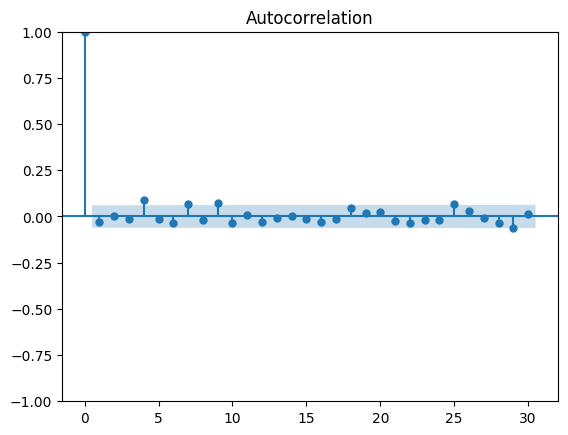

<Figure size 1200x500 with 0 Axes>

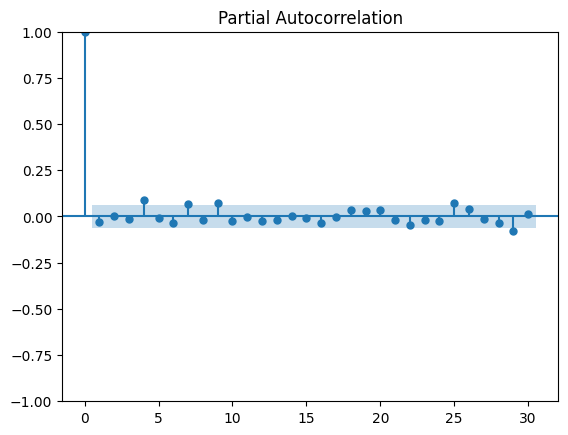

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(train_diff, lags=30)
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(train_diff, lags=30)
plt.show()

**Fit Candidate ARIMA Models**

Objective: Train multiple ARIMA models with different (p,d,q) values.

Fit each candidate ARIMA model on the training dataset.

Compare AIC (Akaike Information Criterion) to select the best model.

Lower AIC indicates better balance between goodness-of-fit and model complexity.

We use the order with the lowest AIC for forecasting.

In [16]:
from statsmodels.tsa.arima.model import ARIMA

orders = [(1,1,1), (2,1,1), (1,1,2)]
models = {}
results = {}

for order in orders:
    print(f"\nFitting ARIMA{order}...")
    model = ARIMA(train['Price'], order=order)
    model_fit = model.fit()
    models[order] = model_fit
    results[order] = model_fit.aic
    print(f"AIC for ARIMA{order}: {model_fit.aic}")


Fitting ARIMA(1, 1, 1)...
AIC for ARIMA(1, 1, 1): 7395.975643097809

Fitting ARIMA(2, 1, 1)...
AIC for ARIMA(2, 1, 1): 7398.519047406873

Fitting ARIMA(1, 1, 2)...


C:\Users\sneha\lstm_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sneha\lstm_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC for ARIMA(1, 1, 2): 7397.975035554655


In [17]:
best_order = min(results, key=results.get)
print("Best ARIMA order based on AIC:", best_order)

best_model = models[best_order]

Best ARIMA order based on AIC: (1, 1, 1)


**Forecasting**

Objective: Predict stock prices on the test dataset using the best ARIMA model.

Compare predicted vs actual prices visually.

The forecast gives us insight into how well ARIMA captures trends in the stock data.

In [18]:
forecast_arima = best_model.forecast(steps=len(test))
forecast_arima.index = test.index

**Model Evaluation**

Metrics Used:

Mean Absolute Error (MAE)

Mean Squared Error (MSE)

Root Mean Squared Error (RMSE)

These metrics help quantify prediction accuracy. Lower values indicate better performance.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_arima = mean_absolute_error(test['Price'], forecast_arima)
mse_arima = mean_squared_error(test['Price'], forecast_arima)
rmse_arima = np.sqrt(mse_arima)

print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)

ARIMA MAE: 58.67932237201112
ARIMA RMSE: 73.67990485342398


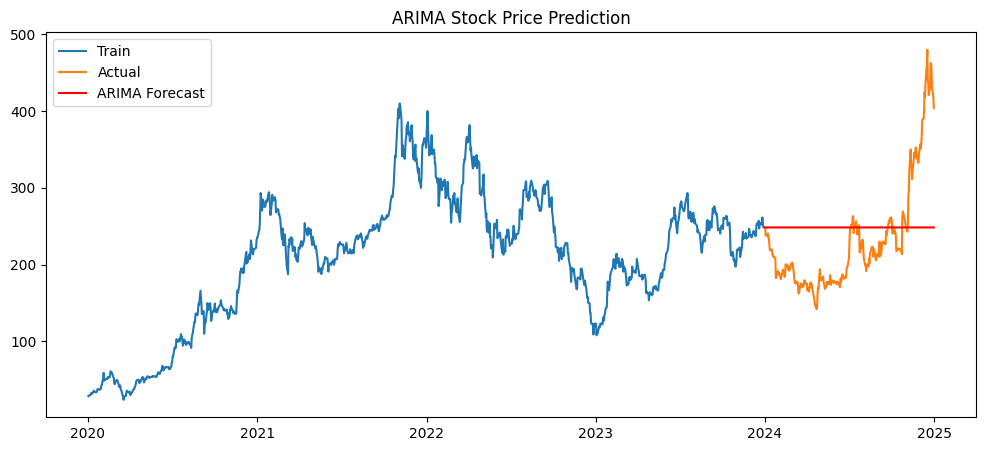

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Actual')
plt.plot(forecast_arima, label='ARIMA Forecast', color='red')
plt.title("ARIMA Stock Price Prediction")
plt.legend()
plt.show()

**Residual Diagnostics**

Objective: Verify ARIMA assumptions:

Plot residuals over time → should resemble white noise.

Plot residual density → should be approximately normal.

Residual mean should be close to zero.

If residuals are not random → ARIMA may not fully capture the series dynamics.

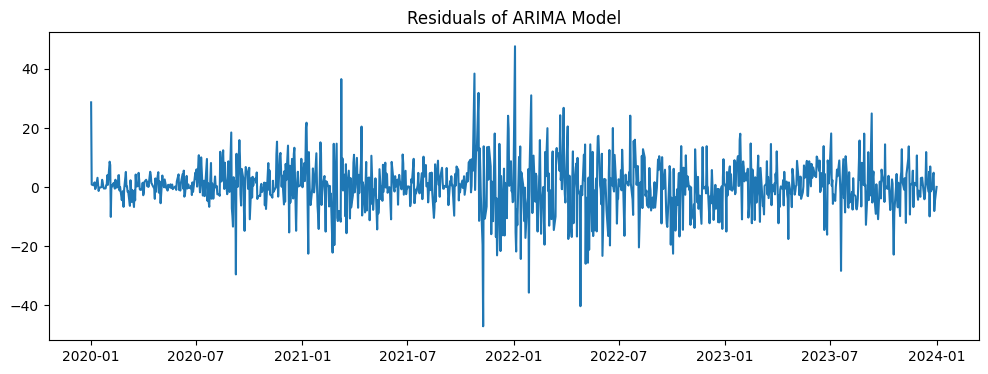

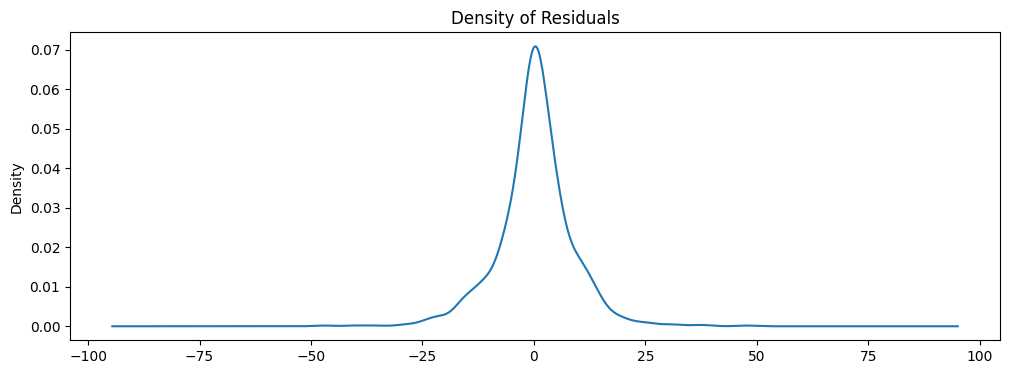

Mean of Residuals: 0.24230565896465966


In [21]:
residuals = best_model.resid

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.show()

plt.figure(figsize=(12,4))
residuals.plot(kind='kde')
plt.title("Density of Residuals")
plt.show()

print("Mean of Residuals:", residuals.mean())

<h1> LSTM Model </h1>

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts[['Price']])

**Creating Supervised Learning Data (Sliding Window)**

We transform the time series into input-output pairs where the model learns to predict the next value based on the previous 60 days.

In [23]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1244, 60)
Shape of y: (1244,)


In [24]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [25]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 995
Testing samples: 249


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential()

model_lstm.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=64, return_sequences=False))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.summary()

C:\Users\sneha\lstm_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ lstm (LSTM)                   │ (None, 60, 64)        │       16,896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 60, 64)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_1 (LSTM)                 │ (None, 64)            │       33,024 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_1 (Dropout)           │ (None, 64)            │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 1)             │           65 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0232 - val_loss: 0.0059
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0

**LSTM Predictions**

In [28]:
pred_lstm = model_lstm.predict(X_test)

# Convert back to original scale
pred_lstm = scaler.inverse_transform(pred_lstm)
actual_lstm = scaler.inverse_transform(y_test.reshape(-1,1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_lstm = mean_absolute_error(actual_lstm, pred_lstm)
mse_lstm = mean_squared_error(actual_lstm, pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)

print("LSTM MAE:", mae_lstm)
print("LSTM RMSE:", rmse_lstm)

LSTM MAE: 12.316035259200863
LSTM RMSE: 18.315164352810953


**Plot LSTM Predictions**

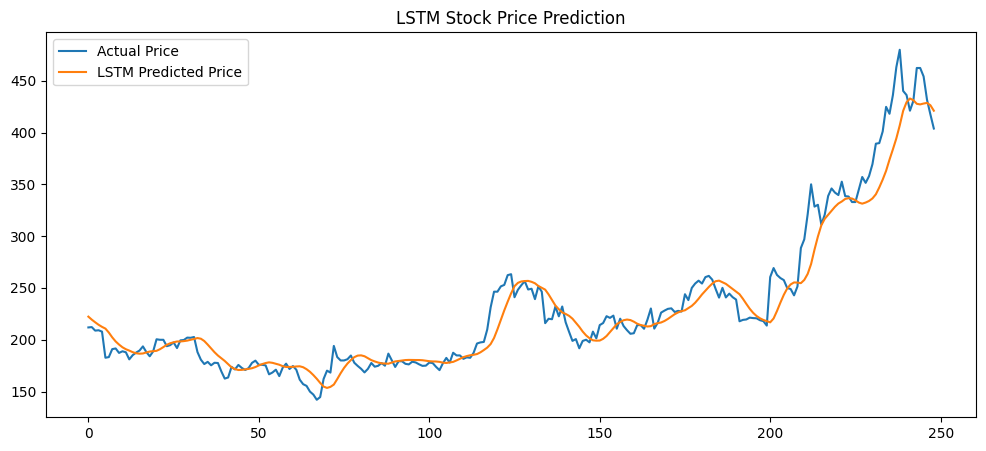

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(actual_lstm, label='Actual Price')
plt.plot(pred_lstm, label='LSTM Predicted Price')
plt.title("LSTM Stock Price Prediction")
plt.legend()
plt.show()

**Learning Curve**

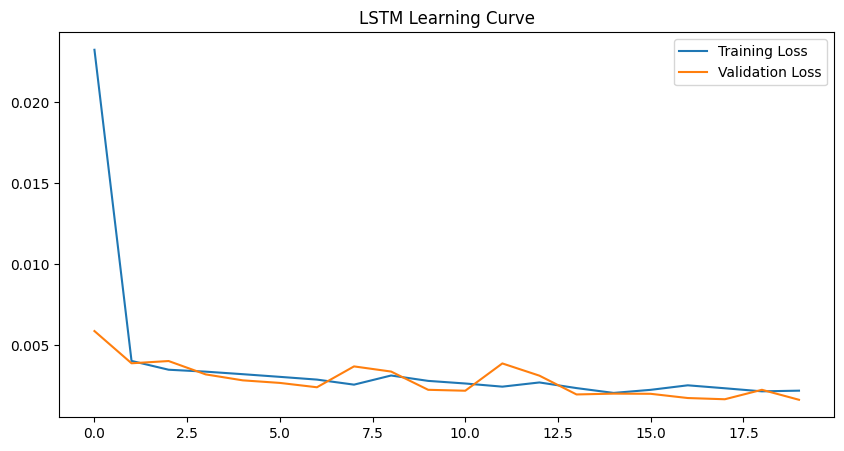

In [31]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Learning Curve")
plt.legend()
plt.show()

**Model Comparison: ARIMA vs LSTM**

In [32]:
mape_arima = np.mean(np.abs((test['Price'].values - forecast_arima.values) / test['Price'].values)) * 100
mape_lstm = np.mean(np.abs((actual_lstm - pred_lstm) / actual_lstm)) * 100

print("ARIMA -> MAE:", mae_arima, " RMSE:", rmse_arima, " MAPE:", mape_arima)
print("LSTM  -> MAE:", mae_lstm, " RMSE:", rmse_lstm, " MAPE:", mape_lstm)


ARIMA -> MAE: 58.67932237201112  RMSE: 73.67990485342398  MAPE: 26.083294032933946
LSTM  -> MAE: 12.316035259200863  RMSE: 18.315164352810953  MAPE: 5.012901972607615


**Final Visualization: ARIMA vs LSTM**

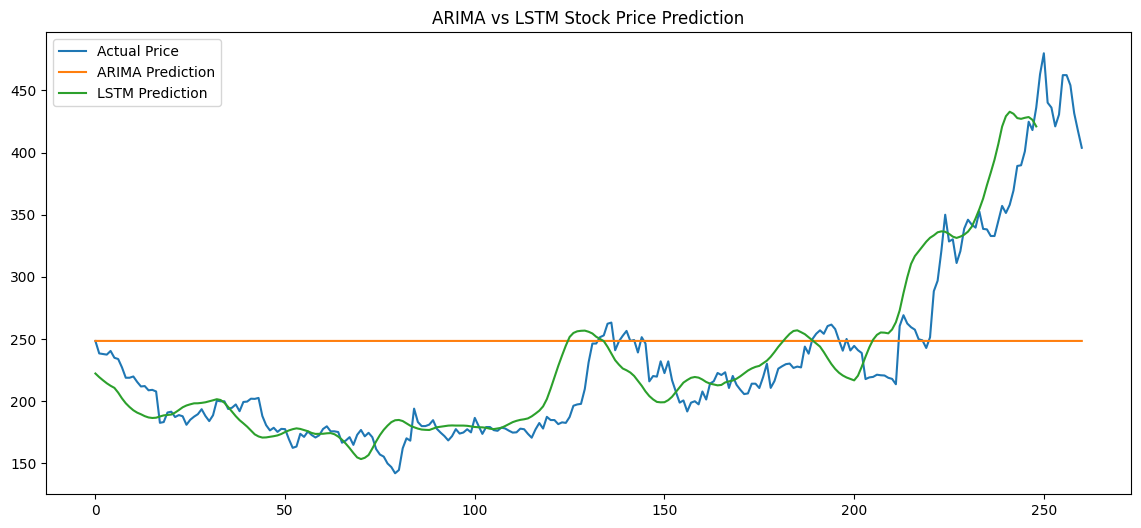

In [33]:
plt.figure(figsize=(14,6))
plt.plot(test['Price'].values, label='Actual Price')
plt.plot(forecast_arima.values, label='ARIMA Prediction')
plt.plot(pred_lstm, label='LSTM Prediction')
plt.title("ARIMA vs LSTM Stock Price Prediction")
plt.legend()
plt.show()